# Introduction

In free recall studies of memory, participants study a list of words and then try to recall them in any order they want. These studies have found that when words were presented near to one another on a list, people tend to recall them together during free recall. Based on this finding, researchers have proposed that memories include information about a mental representation of temporal context that functions like a mental timeline. Words associated with similar temporal contexts tend to be recalled together, because one word will remind the participant of other words associated with similar temporal contexts.

If mental temporal context helps organize memory in free recall experiments, then it may also affect other types of memory tests. Osth and Fox (2019) ran a new memory study to test this hypothesis. They had participants study a list of word pairs. Participants were asked to study each pair for a later memory test. During the test phase, they were presented with word pairs that were either intact (that is, the same as one of the pairs they saw before) or rearranged (that is, two words taken from different pairs). They manipulated the lag between the words of the rearranged pairs. For example, if a rearranged pair was selected from two pairs that were adjacent in the list, that pair would have a lag of 1. The lag varied from 1 to 5, allowing the authors to test if nearby rearranged pairs were more likely to be confused with intact pairs. They predicted that, if temporal context is associated with memories, then it should make adjacent rearranged pairs seem more familiar, leading to more false alarms.

# Results

## Read raw data and get test trials

First, I read the raw data and filtered it to get just the test trials.

In [1]:
import polars as pl
import seaborn as sns
import pingouin as pg
from project import task
data_file = task.get_data_file()
raw = task.read_data(data_file)
df = raw.filter(pl.col("phase") == "test")
df.head()

subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
i64,i64,i64,str,str,str,str,i64,f64,i64,i64
101,0,-1,"""test""","""rearranged""","""waste""","""degree""",0,2.312,1,2
101,0,0,"""test""","""rearranged""","""needed""","""able""",0,3.542,1,1
101,0,1,"""test""","""rearranged""","""single""","""clean""",0,2.084,1,3
101,0,2,"""test""","""rearranged""","""train""","""useful""",0,1.669,1,2
101,0,3,"""test""","""rearranged""","""knees""","""various""",0,2.326,1,5


## Exclude responses that were too fast
Following the original paper's analysis, I excluded responses that were faster than 0.5 s. Associative recognition responses faster than 0.5 s are generally not expected to be accurate, based on how long it usually takes humans to make these kinds of decisions.

In [9]:
df_filt = task.exclude_fast_responses(df, thresh=0.5)
prev_null = df["RT"].is_null().sum()
null = df_filt["RT"].is_null().sum()
print(f"Excluded {null - prev_null} short responses of {df.shape[0] - prev_null}.")
df_filt.describe()

Excluded 1274 short responses of 53647.


statistic,subj,cycle,trial,phase,type,word1,word2,response,RT,correct,lag
str,f64,f64,f64,str,str,str,str,f64,f64,f64,f64
"""count""",53700.0,53700.0,53700.0,"""53700""","""53700""","""53700""","""53700""",52373.0,52373.0,53700.0,26850.0
"""null_count""",0.0,0.0,0.0,"""0""","""0""","""0""","""0""",1327.0,1327.0,0.0,26850.0
"""mean""",165.655866,3.496089,28.5,null,null,null,null,0.374143,1.356705,0.656648,3.0
"""std""",99.008229,2.289598,17.318264,null,null,null,null,0.483905,0.750938,0.474832,1.41424
"""min""",101.0,0.0,-1.0,"""test""","""intact""","""ability""","""ability""",0.0,0.5,0.0,1.0
"""25%""",128.0,1.0,14.0,null,null,null,null,0.0,0.899,0.0,2.0
"""50%""",158.0,3.0,29.0,null,null,null,null,0.0,1.14,1.0,3.0
"""75%""",186.0,5.0,43.0,null,null,null,null,1.0,1.543,1.0,4.0
"""max""",1150.0,7.0,58.0,"""test""","""rearranged""","""youth""","""youth""",1.0,7.925,1.0,5.0


## Responses by memory condition

In this study, a response is a "hit" if the pair was intact and the participant responded "intact". A response is a "false alarm" if the pair was rearranged and the participant responded "intact". First, I created a table to summarize performance for each participant.

In [3]:
resp = (
    df_filt.group_by("subj", "type")
    .agg(pl.col("response").mean())
    .sort("subj", "type")
)
resp

subj,type,response
i64,str,f64
101,"""intact""",0.76569
101,"""rearranged""",0.108333
102,"""intact""",0.285714
102,"""rearranged""",0.241667
103,"""intact""",0.866667
…,…,…
212,"""rearranged""",0.532051
213,"""intact""",0.640693
213,"""rearranged""",0.460526


I used a bar plot to visualize response frequency for intact and rearranged pairs. Participants were more likely to respond "yes" when the pair was intact. Error bars indicate 95% bootstrap confidence intervals.

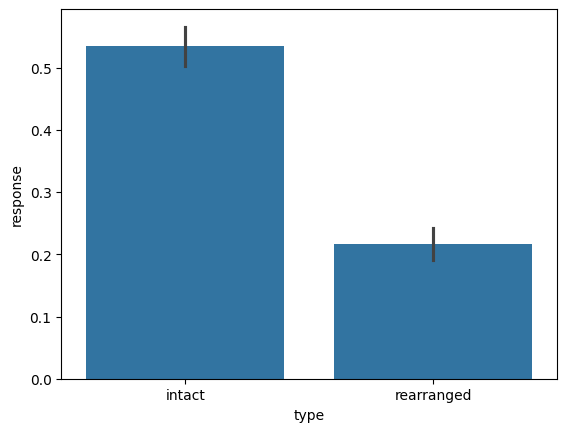

In [4]:
sns.barplot(resp, x="type", y="response");

Next, I tested whether the rate of responding "yes" was greater for intact pairs compared to rearranged pairs. There was a significant difference between conditions (t(111) = 15.5, p < 0.05), with more "yes" responses for intact pairs compared to rearranged pairs. This result indicates that memory performance was greater than chance.

In [5]:
tab = (
    resp.pivot("type", index="subj", values="response")
    .select(subj="subj", hr="intact", far="rearranged")
)
pg.ttest(tab["hr"], tab["far"], paired=True)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,15.74889,111,two-sided,4.599876e-30,"[0.28, 0.36]",2.088744,7.037e+26,NaN


## Calculate false alarm rate by pair lag

The main question of the study focused on the rearranged pairs, which varied in the lag between them in the list. Some pairs were drawn from adjacent pairs (lag 1), while others had four pairs between them (lag 5). I next examined whether participants were more likely to respond "yes" to rearranged pairs that had a smaller lag (that is, that were closer together in the list).

In [6]:
resp_lag = (
    df_filt.filter(pl.col("type") == "rearranged")
    .group_by("subj", "lag")
    .agg(pl.col("response").mean())
    .sort("subj", "lag")
)
resp_lag

subj,lag,response
i64,i64,f64
101,1,0.0625
101,2,0.1875
101,3,0.0625
101,4,0.125
101,5,0.104167
…,…,…
1150,1,0.270833
1150,2,0.1875
1150,3,0.166667


I used a line plot to examine how the probability of a "yes" response changes with lag. There doesn't seem to be much relationship between lag and "yes" probability. Error bands indicate 95% bootstrap confidence intervals.

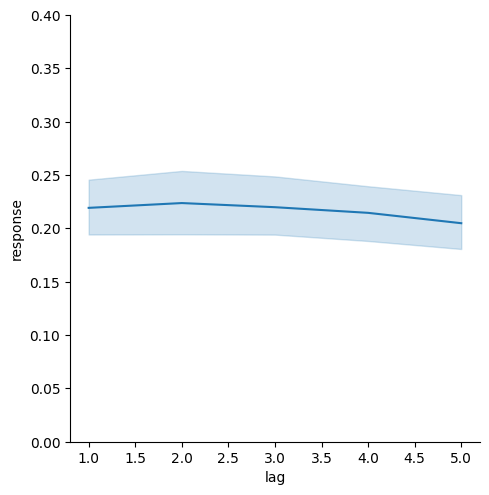

In [7]:
sns.relplot(resp_lag, x="lag", y="response", kind="line").set(ylim=(0, 0.4));

I next used a repeated-measures ANOVA to test whether the probability of responding "yes" varied with lag. I found that there was not a significant relationship between false alarm responses and lag (F(4, 444) = 1.80, p > 0.05).

In [8]:
pg.rm_anova(data=resp_lag.to_pandas(), dv="response", within="lag", subject="subj")

,Source,ddof1,ddof2,F,p-unc,p-GG-corr,ng2,eps,sphericity,W-spher,p-spher
0,lag,4,444,1.70863,0.146973,0.151728,0.001886,0.931939,False,0.853225,0.043279


# Discussion

I reproduced the findings of Osth and Fox (2019) that lag did not influence the tendency of participants to mistake rearranged pairs for intact pairs. This finding suggests that participants did not form cross-pair associations. It also suggests that, if temporal context is associated with memories, then it does not influence the perceived familiarity of associations between pairs of words.

Performance on the associative recognition test was well above chance, but still included a substantial proportion of false alarms, so it seems unlikely that the analysis failed to detect an effect due to a lack of statistical power. My analysis used a frequentist, rather than Bayesian, approach, in contrast to the original analysis. The original Bayesian analysis provided clearer evidence for a lack of an effect of lag on associative memory, further suggesting that the null effect observed in this dataset was not due to a lack of statistical power.